In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
import pyPamtra
import os
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import sys
reload(pyPamtra)


/home/vagrant/lib/python/pyPamtra/meteoSI.py:19: Warning: numexpr not available
  warnings.warn("numexpr not available", Warning)
/home/vagrant/lib/python/pyPamtra/importer.py:17: Warning: numexpr not available
  warnings.warn("numexpr not available", Warning)


<module 'pyPamtra' from '/home/vagrant/lib/python/pyPamtra/__init__.pyc'>

In [2]:
def field_size_distribution(mode, T, D, M2=None):
#FIELD_SIZE_DISTRIBUTION
#   Compute ice size distributions from the parameterization of either Field
#   et al. (2005) or Field et al. (2007).  The arguments are:
#      mode   Can be one of "2005", "2007tropical" or "2007midlatitude"
#      T      Temperature (degrees C) - must be a scalar
#      D      Particle maximum dimension (m) - can be a vector
#      M2     Second moment of the size distribution (m3) - can be a
#             vector, and can be omitted to get the default values
#      n      Number concentration (m-4) in the form of a matrix of size
#             length(D) x length(M2)
#
# field_size_distribution function written by R. Hogan

# Default second moment values

  if M2 is None: 
    M2 = 10**np.arange(-5,-0.49,0.10)

  moment = 3

  if mode.startswith('2005'):
    # Field et al. (2005)
    A = 10**(5.065339 - 0.062659*T -3.032362*moment + 0.029469*T*moment 
            -0.000285*T**2 +0.31255*moment**2 + 0.000204*T**2*moment 
            +0.003199*T*moment**2 -0.015952*moment**3)
    B = 0.476221 - 0.015896*T + 0.165977*moment + 0.007468*T*moment \
        -0.000141*T**2 +0.060366*moment**2 +0.000079*T**2*moment \
        +0.000594*T*moment**2 -0.003577*moment**3
    M3 = A*M2**B
  elif mode.startswith('2007'):
    # Field, Heymsfield and Bansemer (2007)
    A = np.exp(13.6-7.7*moment+0.479*moment**2)
    B = -0.0361+0.0151*moment+0.00149*moment**2
    C = 0.807+0.00581*moment+0.0457*moment**2
    M3 = A*np.exp(B*T)*M2**C
  else:
    raise ValueError('Mode "'+ mode +'" not understood (should be 2005, 2007tropical or 2007midlatitude)')

  # Length scale derived from 2nd and 3rd moments
  L23 = M3/M2

  # Normalized number concentration from 2nd and 3rd moments
  N023 = M2**4/M3**3

  n = np.zeros((len(D), len(M2)))

  # Loop over mean sizes
  for im in range(len(M2)):
    x = D[:]/L23[im]

    if mode.startswith('2005'):
      n[:,im] = N023[im]*(490.6*np.exp(-20.78*x)+17.46*x**0.6357*np.exp(-3.290*x))
    elif mode.endswith('tropical'):
      n[:,im] = N023[im]*(152*np.exp(-12.4*x)+3.28*x**-0.78*np.exp(-1.94*x))
    elif mode.endswith('midlatitude'):
      n[:,im] = N023[im]*(141*np.exp(-16.8*x)+102*x**2.07*np.exp(-4.82*x))
    else:
      raise ValueError('Mode "'+ mode +'" not understood (should be 2005, 2007tropical or 2007midlatitude)')
  return n

/home/vagrant/lib/python/pyPamtra/core.py:681: UserWarning: No descriptor file defined. Assuming dry profile without hydrometeors
  warnings.warn("No descriptor file defined. Assuming dry profile without hydrometeors")
/home/vagrant/lib/python/pyPamtra/core.py:786: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/vagrant/lib/python/pyPamtra/core.py:803: Warning: lat set to 50.938056
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/vagrant/lib/python/pyPamtra/core.py:803: Warning: lon set to 6.956944
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/vagrant/lib/python/pyPamtra/core.py:803: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/vagrant/lib/python/pyPamtra/core.py:803: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/vagrant/lib/python/pyPamtra/core.py:803: Warning: groundtemp set to nan
  warnings.warn("%s set to

Text(0,0.5,'IWC [g/m^3]')

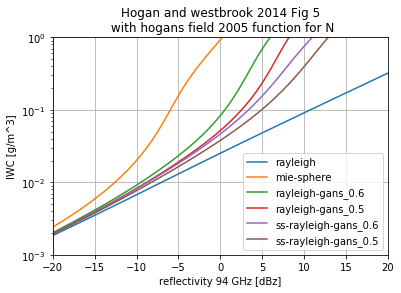

In [3]:
freqs = [94]

nIwc = 46
nbins=250
verbose = 0
#plt.close("all")
plt.figure()

scats =   ["rayleigh","mie-sphere","rayleigh-gans_0.6","rayleigh-gans_0.5","ss-rayleigh-gans_0.6","ss-rayleigh-gans_0.5"]#,"rayleigh-gans_0.5","rayleigh-gans_0.6","ss-rayleigh-gans_0.5","ss-rayleigh-gans_0.6"]
#scats =   ["ss-rayleigh-gans_0.5","ss-rayleigh-gans_0.6"]

#scats = ["rayleigh-gans_0.6"]
for scat in scats:

  try: aspect = float(scat.split("_")[-1])
  except: aspect = 1.

  pam = pyPamtra.pyPamtra()
  pam = pyPamtra.importer.createUsStandardProfile(pam,hgt_lev=np.array([np.arange(1000,1300,200)]*nIwc))

  pam.nmlSet["hydro_fullspec"] = True
  pam.df.addHydrometeor(('ice', -99.0, -1,   -99.0,  -99.0, -99.0,  -99.,  -99., 0, nbins, 'fullspec', -99.0, -99.0, -99.0, -99.0, 20e-5,  0.05, scat.split("_")[0], 'heymsfield10_particles',0.0))

  ms_a = 0.012
  ms_b =  1.9
  dD = 20e-5
  Dlong = np.arange(dD,0.050001,dD)
  Dlong_bound = np.arange(dD/2.,0.050001+dD/2.,dD)
  Dshort = Dlong * aspect
  mass = ms_a * Dlong**ms_b
  mass_bound = ms_a * Dlong_bound**ms_b
  rho0 = 917.
  mass_max = (np.pi*rho0/6) * Dlong**3 *aspect
  mass[mass>mass_max] = mass_max[mass>mass_max]
  mass_bound_max = (np.pi*rho0/6) * Dlong_bound**3 *aspect
  mass_bound[mass_bound>mass_bound_max] = mass_bound_max[mass_bound>mass_bound_max]
  volume = mass/rho0
  volume_bound = mass_bound/rho0
  field_mode = "2005"
  n = field_size_distribution(field_mode, 0, Dlong)
  IWC = np.sum(n* mass[:,np.newaxis]*dD,axis=0)
  
  rho_soft =  (6. * mass) / (np.pi *  Dlong**3. * aspect)

  
  d_scat = (volume*6./np.pi)**(1./3.)
  d_scat_bound = (volume_bound*6./np.pi)**(1./3.)
  d_scat_delta = np.diff(d_scat_bound)
  
  
  pam.df.addFullSpectra()
 
  pam.df.dataFullSpec["as_ratio"][:] = aspect
  if scat.split("_")[0] in ["mie-sphere","rayleigh-gans","ss-rayleigh-gans"]: #soft sphere
    pam.df.dataFullSpec["d_bound_ds"][:,0,0,0,:] = Dlong_bound
    pam.df.dataFullSpec["d_ds"][:,0,0,0,:] = Dlong
    pam.df.dataFullSpec["rho_ds"][:,0,0,0,:] = rho_soft
  else: #"solid" sphere for pure rayleigh!
    pam.df.dataFullSpec["d_bound_ds"][:,0,0,0,:] = d_scat_bound
    pam.df.dataFullSpec["d_ds"][:,0,0,0,:] = d_scat
    pam.df.dataFullSpec["rho_ds"][:,0,0,0,:] = rho0
  pam.df.dataFullSpec["n_ds"][:,0,0,0,:] = n.T * dD
  pam.df.dataFullSpec["area_ds"][:,0,0,0,:] = np.pi/4. *  pam.df.dataFullSpec["d_ds"][0,0,0,0,:] ** 2
  pam.df.dataFullSpec["mass_ds"][:,0,0,0,:] =mass


  pam.p["temp_lev"][:] =273.15  

  pam.p["hydro_q"][:,0,0,0] = IWC #/ rho


  pam.set["verbose"] = verbose
  pam.set["pyVerbose"] =verbose
  pam.nmlSet["passive"] = False
  pam.nmlSet["save_psd"] = True


  pam.runPamtra(freqs,checkData=False)

  if pam.fortError>0: raise SystemError("Fortran error")

  #IWC = 

  plt.plot(pam.r["Ze"][:,0,0,0,0],IWC * 1000, label =scat)
plt.xlim(-20,20)
plt.ylim(1e-3,1)
plt.yscale("log")
plt.legend(loc="lower right")
plt.grid()
plt.title("Hogan and westbrook 2014 Fig 5\n with hogans field 2005 function for N")
plt.xlabel("reflectivity 94 GHz [dBz]")
plt.ylabel("IWC [g/m^3]")

Text(0,0.5,'IWC [g/m^3]')

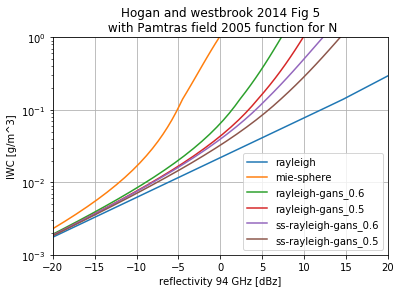

In [4]:
plt.figure()
for scat in scats:

  try: aspect = float(scat.split("_")[-1])
  except: aspect = 1.

  pam = pyPamtra.pyPamtra()
  pam = pyPamtra.importer.createUsStandardProfile(pam,hgt_lev=np.array([np.arange(1000,1300,200)]*nIwc))


  if scat.split("_")[0] in ["rayleigh"]:  #"solid" sphere for pure rayleigh!
    pam.df.addHydrometeor(('ice', aspect, -1,   917,  0.012, 1.9,  -99.,  -99., 3, nbins, 'exp_cosmo_snow', -99.0, -99.0, -99.0, -99.0, 20e-5,  0.05, scat.split("_")[0], 'heymsfield10_particles',0.0))
  else:
    pam.df.addHydrometeor(('ice', aspect, -1,  -99., 0.012, 1.9,  -99.,  -99., 3, nbins, 'exp_cosmo_snow', -99.0, -99.0, -99.0, -99.0, 20e-5,  0.05, scat.split("_")[0], 'heymsfield10_particles',0.0))



  pam.p["temp_lev"][:] =273.15  

  pam.p["hydro_q"][:,0,0,0] = IWC #/ rho


  pam.set["verbose"] = verbose
  pam.set["pyVerbose"] =verbose
  pam.nmlSet["passive"] = False
  pam.nmlSet["save_psd"] = True


  pam.runPamtra(freqs,checkData=False)

  if pam.fortError>0: raise SystemError("Fortran error")


  plt.plot(pam.r["Ze"][:,0,0,0,0],IWC * 1000, label =scat)
plt.xlim(-20,20)
plt.ylim(1e-3,1)
plt.yscale("log")
plt.legend(loc="lower right")
plt.grid()
plt.title("Hogan and westbrook 2014 Fig 5\n with Pamtras field 2005 function for N")
plt.xlabel("reflectivity 94 GHz [dBz]")
plt.ylabel("IWC [g/m^3]")